In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt', quiet=True) # download punkt (if not already downloaded)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as mpl
import matplotlib.pyplot as plt

# change this to your own data directory
data_dir = "data/"

# read and preprocess data
text_file_name = "osdg-community-data-v2023-01-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
text_df.drop(text_df.columns.values[0], axis=1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
text_df.reset_index(inplace=True, drop=True)

```{index} transformation
```

# About Text Data

## Transformation

ML algorithms of any kind expect numerical features with fixed dimensions. This is especially the case for supervised learning algorithms such as classification algorithms, which is what we will be using to classify our texts into the UN SDG categories.

In documents, however, raw text data is typically semi-structured, with uneven lengths and varied contents. This poses a problem for ML methods, which typically operate on numerical vectors of equal length. 

Therefore, once we have our preprocessed text data, our next job is to transform it, and the main way we do this is to *vectorize* it, or transform it into numerical vectors. When we map documents into vectors, we can use several techniques, which we will discuss later: 

* bag of words
* n-grams
* word embedding

Vectorization, and transformation of textual data as a whole, depends on tokenization. Carefully chosen preprocessing steps can help reduce complexity and increase ML model accuracy.

```{index} vectorizations
```

```{index} bag of words
```

### Vectorizations

#### Bag of Words

The **bag of words** approach treats a text or document almost literally as a bag of words; i.e., it ignores the order of the words and simply gathers all the words together in one big collection. All the words are then treated as features, with one feature for each word, where the value of the feature is the number of times that word appears in the document. We then set a fixed number of words to be considered, and our bag of words becomes the vocabulary we work with. 

Let's analyze the vocabulary of our UN SDG dataset. We use `CountVectorizer()` from the `scikit-learn` library to create our bag of words, *fitting* it to the corpus to make it learn the vocabulary and *transforming* it into a matrix called `cv_fit` that gives the token counts for each term in each document. (This matrix is called a **document-term matrix**, a concept which will be explained more fully later on in this section.)

In [2]:
docs = text_df.text
cv = CountVectorizer()
cv_fit = cv.fit_transform(docs) 

Each row in `cv_fit` represents a bag of words for the corresponding document. Here are the first five rows:

In [3]:
cv_fit[0:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We can use the function `get_feature_names_out()` to retrieve the learned vocabulary tokens, which have become the features of the bag of words. For example, the first feature (at index 0) is the token "00", and the last feature (at index 45737) is the token "四个全面".

In [4]:
feature_names = cv.get_feature_names_out()
print('Number of features:', len(feature_names))
feature_names

Number of features: 45738


array(['00', '000', '0000002', ..., 'œopen', 'ʿadawiyya', '四个全面'],
      dtype=object)

We can retrieve the total counts for the features by summing the counts in the matrix. We see, for example, that the token "00" occurs eight times in the entire corpus, while the token "四个全面" occurs twice.

In [5]:
total_counts = cv_fit.sum(axis=0)
total_counts

matrix([[  8, 840,   1, ...,   1,   1,   2]])

To get a better idea of how the bag of words works, we can take a look at a short sample text, which is given below.

In [6]:
sample_index = 724
print('Sample text:', text_df.text.iloc[sample_index])
sample_bag = cv_fit[sample_index]

Sample text: Peacemaking, peacekeeping, and peacebuilding may not have the punch and the means of national security, but they are receiving an increasing amount of attention in education, research, and politics.


The `inverse_transform()` function allows us to retrieve a list of all tokens from the vocabulary that occur at least once in the bag of words for this sample text.

In [7]:
cv.inverse_transform(sample_bag)[0]

array(['the', 'of', 'have', 'in', 'and', 'are', 'but', 'education', 'an',
       'research', 'security', 'they', 'may', 'not', 'national',
       'politics', 'amount', 'increasing', 'attention', 'means',
       'peacekeeping', 'receiving', 'peacemaking', 'peacebuilding',
       'punch'], dtype='<U85')

The following code compares the counts of several of these tokens in the sample text to their total counts in the entire corpus. We use the attribute `vocabulary_`, which maps the feature names to their indices, to index into the counts.

In [8]:
tokens = ['and', 'the', 'peacemaking', 'punch', 'unknown']
pd.DataFrame.from_dict(columns=tokens, orient='index', data={
    'sample count': [sample_bag[0, cv.vocabulary_[token]] for token in tokens],
    'total count': [total_counts[0, cv.vocabulary_[token]] for token in tokens]
})

,and,the,peacemaking,punch,unknown
sample count,3,2,1,1,0
total count,93357,143100,44,1,39


Note how the tokens "and" and "the", which are typically considered to be English stop words, occur more frequently than the other tokens. Meanwhile, the word "unknown" has a sample count of 0 because it does not occur in the sample text, even though it occurs 39 times in the rest of the corpus. We also discover that our sample text contains the only occurrence of the token "punch" in the entire corpus. (Words that occur only once in a corpus are known as *hapax legomena*.)

:::{admonition} Exercise 2.1
What is the most common word in the corpus? (Hint: use `argmax()` on `total_counts` to find the index of the token.)
:::

As we have seen, stop words like "and" and "the" are not removed by default. Fortunately, we can easily modify our code to remove stop words:

In [9]:
cv2 = CountVectorizer(stop_words='english') # exclude English stop words
cv2_fit = cv2.fit_transform(text_df.text)

`CountVectorizer()` provides a way to easily retrieve the stop words we are removing:

In [10]:
print(cv2.get_stop_words())

frozenset({'describe', 'whither', 'under', 'back', 'than', 'done', 'beside', 'first', 'up', 'being', 'moreover', 'he', 'detail', 'whereas', 'get', 'sometimes', 'herself', 'eleven', 'such', 'my', 'five', 'made', 'sixty', 'three', 'alone', 'any', 'thus', 'beforehand', 'over', 'which', 'everything', 'eight', 'only', 'move', 'others', 'therein', 'thereupon', 'amoungst', 'his', 'former', 'meanwhile', 'while', 'among', 'for', 'and', 'the', 'own', 'no', 'whence', 'per', 'be', 'whether', 'too', 'ten', 'behind', 'whole', 'she', 'towards', 'along', 'was', 'must', 'but', 'once', 're', 'with', 'who', 'by', 'us', 'except', 'some', 'it', 'have', 'ie', 'ours', 'front', 'whose', 'several', 'indeed', 'rather', 'bill', 'many', 'further', 'full', 'please', 'formerly', 'into', 'because', 'anywhere', 'latter', 'via', 'con', 'everywhere', 'etc', 'fire', 'her', 'you', 'becomes', 'whenever', 'both', 'whereupon', 'beyond', 'from', 'would', 'here', 'thick', 'anyway', 'in', 'nowhere', 'other', 'where', 'becoming

:::{admonition} Exercise 2.2
Find the length of the vocabulary (the number of features) without stop words, and also find the length of the list of stop words. Is the difference between our original vocabulary and our vocabulary with stop words removed equal to the number of stop words? Why or why not?
:::

:::{admonition} Exercise 2.3
What is the most common word now that stop words have been removed?
:::

Now that stop words have been excluded from the vocabulary, the list of vocabulary tokens in our sample text with non-zero counts has changed as well.

In [11]:
sample_bag = cv2_fit[sample_index]
cv2.inverse_transform(sample_bag)[0]

array(['education', 'research', 'security', 'national', 'politics',
       'increasing', 'attention', 'means', 'peacekeeping', 'receiving',
       'peacemaking', 'peacebuilding', 'punch'], dtype='<U85')

```{index} one-hot vectors
```

```{index} numeric count vectors
```

```{index} document-term matrices
```

#### One-Hot Vectors

Another vectorization approach is to treat a text as a **one-hot vector**. This approach lines up all words in the vocabulary and assigns each of them an index $1 \le i \le V$, where $V$ is the number of words in the vocabulary. For each word, it then forms a vector 

$\overrightarrow{w} = (0, 0, …, 0, 1, 0, 0, …, 0)$ , 

with only one 1 in the vector and the rest of the numbers being zeroes. The 1 is at the position $i$ that indexes the word in our vocabulary. The order of the words is ignored, so it does not matter if a certain word is indexed before another one. Because all of the words in our vocabulary are unique, there are no similarity notions among the vectors.

To gain a better understanding of how one-hot vectors work, we can take a look at how a short sample text from the UN SDG dataset would be encoded. As before, we use `NLTK` to tokenize the text.

In [12]:
sample_text = text_df.text.iloc[12737].lower()
print('Sample text:', sample_text)
tokens = nltk.word_tokenize(sample_text)
print('Tokens:', tokens)

Sample text: the chapter examines the contribution that international relations theory has made to the reading and practice of peacebuilding.
Tokens: ['the', 'chapter', 'examines', 'the', 'contribution', 'that', 'international', 'relations', 'theory', 'has', 'made', 'to', 'the', 'reading', 'and', 'practice', 'of', 'peacebuilding', '.']


We also define a convenience function to reshape the list of tokens into a format that can be used by the one-hot encoder:

In [13]:
def ohe_reshape(tokens):
    return np.asarray(tokens).reshape(-1,1)

We use `OneHotEncoder()` from the `scikit-learn` library to create the one-hot encoding. We fit the encoder to our sample text to make it learn the vocabulary. As with `CountVectorizer`, we can view the resulting features using the function `get_feature_names_out()`.

In [14]:
ohe = OneHotEncoder(handle_unknown='ignore') # encode unknown tokens as vectors of all zeros
ohe.fit(ohe_reshape(tokens))
ohe.get_feature_names_out()

array(['x0_.', 'x0_and', 'x0_chapter', 'x0_contribution', 'x0_examines',
       'x0_has', 'x0_international', 'x0_made', 'x0_of',
       'x0_peacebuilding', 'x0_practice', 'x0_reading', 'x0_relations',
       'x0_that', 'x0_the', 'x0_theory', 'x0_to'], dtype=object)

Now that the encoder has learned the vocabulary, we can try it out on text. The following code transforms the first five tokens of our sample text into one-hot encodings by calling the `transform` function:

In [15]:
print('First five tokens:', tokens[:5])
ohe.transform(ohe_reshape(tokens[:5])).toarray()

First five tokens: ['the', 'chapter', 'examines', 'the', 'contribution']


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

Note how, as explained above, each unique token in the learned vocabulary has a unique encoding, with only one 1 in the vector. Note also how the first and fourth vectors in this matrix are identical because they represent the same token, "the".

We can view the unique encoding of "the" by using the `transform` function again:

In [16]:
ohe.transform(ohe_reshape(['the'])).toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

If we try to encode a token that isn't included in the learned vocabulary, however, we get a vector of only zeros:

In [17]:
ohe.transform(ohe_reshape(['unknown'])).toarray()[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

:::{admonition} Exercise 2.4
Verify that each token in the learned vocabulary has a unique encoding.
:::

#### Numeric Count Vectors

A third vectorization approach is to make a numeric vector of counts. This approach counts the occurence of the words in the document and lines up the counts of words in a row for each document. Numeric count vectors are similar to document-term matrices, although they differ in that they measure words rather than tokens (which can be words, but can also be larger units such as phrases or smaller units such as affixes). As a result, we will focus on document-term matrices, which are covered in the next part of this section.

#### Document-Term Matrices

One final vectorization approach we will introduce here is to form a document-term matrix. To form this matrix, we define the matrix's columns to be tokens (such as words or phrases), the matrix's rows to be the documents in the collection, and the value of each entry to be the frequency of each token occuring in the document. Additionally, the values in each entry are weighted frequencies. One weighting method we use is **TF-IDF**, or term frequency (TF) times inverse document frequency (IDF). TF refers to the frequency of the word in the document, while IDF refers to the inverse of the number of documents containing the word divided by number of documents. TF-IDF is discussed later in this section.

Below, we compute a simple document-term matrix for a portion of the documents and tokens in the UN SDG dataset. The features are all unigrams (one-word tokens). While the unigram does provide context for each word, NLP tasks built on such simple model would be disadvantaged.

In [18]:
docs = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vector = count_vectorizer.fit_transform(docs).toarray()
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
count_vector_df.loc[110:120,term_freq.sort_values(by="freq", ascending=False)[:10].term] # take a portion

,countries,women,development,health,water,public,social,education,policy,international
110,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,1,0,0,0,3
112,0,0,4,0,0,0,0,0,0,1
113,0,0,0,1,0,0,0,0,0,0
114,0,0,0,1,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0
116,0,0,2,0,0,0,0,0,1,0
117,2,0,0,0,0,0,1,0,0,0
118,0,4,4,1,0,0,1,0,0,0
119,0,0,0,0,0,0,0,0,0,0


:::{admonition} Exercise 2.5
Look at document 118. 
* What are the most frequent words for this document?
* Refer to the UN SDGs. What is your best guess as to which goal this document describes?
:::

```{index} n-grams
```

### N-Grams

An n-gram is a contiguous sequence of $n$ items from a text. Items in an n-gram are tokens we choose to include through preprocessing, but these items can also include markers we add to the data to serve the NLP tasks at hand. 

For example, if we were to find what words are often used at the beginning or end of a sentence, we would add &lt;s&gt; and &lt;/s&gt; as markers for the beginnings and ends of sentences, to denote the sentence boundaries. We would then build bigrams $(n=2)$; for the sentence "I built an AI machine”, we would get the items 
(&lt;s&gt; I), (I built), (built an), (an AI), (AI machine), and (machine &lt;/s&gt;). We then count the frequency of bigrams. specifically of the form (&lt;s&gt; \*) and (\* &lt;/s&gt;), where \* represents any other token.

In the previous subsection, we looked at a document-term matrix of unigrams (with stop words removed). We can check the total count of unigrams — as well as the number of *unique* unigrams — with the following code. Notice how the second number is smaller than the first because many of the unigrams occur more than once in the corpus.

In [19]:
print('Total count of unigrams (without stop words):', count_vector.sum())
print('Number of unique unigrams (without stop words):', len(count_vectorizer.vocabulary_))

Total count of unigrams (without stop words): 1351051
Number of unique unigrams (without stop words): 45440


We then compare this to the counts obtained when stop words are not removed, which we calculate using the `cv` and `cv_fit` objects from earlier in this section:

In [20]:
print('Total count of unigrams (with stop words):', cv_fit.sum())
print('Number of unique unigrams (with stop words):', len(cv.vocabulary_))

Total count of unigrams (with stop words): 2335467
Number of unique unigrams (with stop words): 45738


Notice that stop word removal alone reduced the total count of terms by around 42%, even though it decreased the number of unique terms in the vocabulary only slightly.

Next, we can check the bigrams for our document corpus by setting the `ngram_range` parameter to `CountVectorizer`:

In [21]:
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english') 
count_vector = count_vectorizer.fit_transform(docs)
print('Total count of bigrams (without stop words):', count_vector.sum())
print('Number of unique bigrams (without stop words):', len(count_vectorizer.vocabulary_))

Total count of bigrams (without stop words): 1326382
Number of unique bigrams (without stop words): 834465


:::{admonition} Exercise 2.6
 Notice that the number of unique bigrams is larger than the number of unique unigrams, even though the total count of bigrams is smaller than the total count of unigrams. Why might this be the case?
:::

:::{admonition} Exercise 2.7
 Modify the above code to get the counts of the trigrams without stop words. Is the total count of trigrams larger or smaller than the total count of bigrams? What about the number of unique trigrams compared to the number of unique bigrams? Why might this be the case?
:::

```{index} probabilistic language modeling
```


```{index} joint probability
```

### Probabilistic Language Modeling

So far, we have worked with clearly defined texts and sequences of words. But sometimes, the texts we get are incomplete, or we might want to reduce computational time by only giving portions of the text. As such, we might turn to probabilistic language modeling. Typically, a probabilistic language model analyzes a body of text data and computes the following based on that body of text data: 

 - the probability of a sentence or sequence of words occurring, $P(w_1, w_2, w_3, … , w_n)$,
 - the probability of the next word given $k$ words, $P(w_n | w_{(n-k)}, w_{(n-(k-1))}, … , w_{(n-1)})$.


We then use the chain rule to compute the joint probability: 

$P(A \cap B) = P(B|A)*P(A)$ 

$\implies P(w_1, w_2, w_3, …, w_n) = 
P(w_1)P(w_2|w_1)P(w_3|w_1,w_2)...P(w_n|w_1, …, w_{(n-1)})$.


We could estimate the probability by calculating

$\text{count}(w_1, w_2, …, w_{(i-1)}, w_i) / \text{count}(w_1, w_2, …, w_{(i-1)})$,

but with too many possible occurrences, this calculation is not feasible.

Instead, we can simplify the equation through the Markov Assumption, which in an NLP context assumes that the next word only depends on some previous words, not all of them. This means we can place a condition on the previous $k$ words rather than all the previous words:

$P(w_n|w_1, w_2, w_3, …, w_{(n-1)}) \sim  P(w_n|w_{(n-k)}, …, w_{(n-1)})$.

When considering a unigram $(n=1)$ model, we calculate the probability as

$P(w_1, w_2, w_3, …, w_n) = P(w_1)P(w_2)P(w_3)...P(w_n)$.

A similar process occurs when considering a bigram $(n=2)$ model, where we place a condition on the previous word,

$P(w_n|w_1, …, w_{(n-1)}) \sim P(w_i|w_{(i-1)})$,

and we can similarly extend this process to trigrams, 4-grams, 5-grams, or any n-gram.

However, no matter how many $n$ we consider, we still will not arrive at a sufficient model; language has long-distance dependencies that require extremely large $n$ that can even extend to previous sentences and/or documents. To truly determine if our n-gram is sufficient, we extrinsically evaluate it by putting our model to tasks. For example, if we only want to deal with spell correction, a unigram be sufficient, but for machine translation, we might need to work with very long sentences. Google’s recent speech model features 20B sentences (https://arxiv.org/abs/2303.01037?utm_source=substack&utm_medium=email). 




```{index} natural language generation
```

### Natural Language Generation

Natural Language Generation (NLG) is an offshoot of Probabilistic Language Modeling which is used to generate texts. Given a prompt (such as a short incomplete sentence), NLG models will generate text in response (such as giving the next few words of the sentence).

:::{admonition} Exercise 2.8
Visit this Hugging Face demo, which attempts to predict the next token when given part of a sentence: https://alonsosilva-nexttokenprediction.hf.space/. Try typing in a few incomplete sentences. How accurate are the model's predictions? 
:::

As the exercise shows, these language models are not perfect. But especially with recent developments in AI, they are improving. 

Another main role of NLG is automatic summarization of a text. The NLG has the ability to perform extractive summarization (extracting meaning from a text), or abstractive summarization (constructing an abstract from a text). NLG can also be used for topic modeling to identify the main topics of the text, or as an advanced machine translation tool.

An example of an advanced natural language generator is the Generative Pre-trained Transformer (GPT), mainly pioneered by the startup OpenAI. The GPT is a text generation deep learning model trained on massive datasets, including internet data, book data, GitHub data, and more. GPTs, including the famous ChatGPT, can take thousands of words as input and have been trained on billions of different parameters.

```{index} features
```

```{index} TF-IDF (term frequency, inverse document frequency
```

## Features

### TF-IDF (Term Frequency, Inverse Document Frequency)

In the document-term matrix previously discussed, we represented columns as tokens, rows as documents, and the entry values as the number of occurrences of that token in the document. However, using the counts alone may not give us an accurate picture of how significant each token is in context, since some tokens naturally occur more frequently than others. We can ameliorate this problem by weighting the frequencies with TF-IDF.

In our computation of the matrix cell $(d,t)$ with document as row and term as column, we compute the following:

 - TF: term frequency of term $t$ in the document $d$ = 
count of term $t$ in document $d$ divided by total number of terms in document $d$
 - DF: document frequency of term $t$ = 
number of documents containing term $t$ divided by total number of documents
$\frac{\text{df}}{N}$, where $N$ is the total number of documents and is a constant that can be ignored
 - IDF: take the inverse of DF
 - TF-IDF = TF * IDF

We can use `scikit-learn` to get TF-IDF with `scikit-learn.feature_extraction.text.TfidfVectorizer`. This code takes several arguments:

 - `sublinear_df` : Boolean; if true, uses a logarithmic form for frequency,
 - `min_df` : the minimum number of documents a word must be present in to be kept,
 - `norm`: usually set to l2 to ensure all our feature vectors have a Euclidean norm of 1,
 - `ngram_range`: determines whether to take unigrams, bigrams, or both, and
 - `stop_words`:  usually set to "english" for removing English stop words.

Note that when using logarithmic form for term frequency, the weighted TF is transformed into $1 + \log \text{TF}$; if $\text{TF} > 0$, then $\text{TF} = 0$; otherwise, we use $\log\frac{N}{\text{df}}$ for IDF to dampen the effect of $\frac{N}{\text{df}}$.

As an example, we compute the same document-term matrix as before, but this time using `TfidfVectorizer`. We include only unigrams and remove English stop words.

In [69]:
docs = text_df.text
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfidf_vector = tfidf_vectorizer.fit_transform(docs).toarray()
tfidf_vector_df = pd.DataFrame(tfidf_vector, columns=tfidf_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": tfidf_vector_df.columns.values, "freq" : tfidf_vector_df.sum(axis=0)})
tfidf_vector_df.loc[110:120,term_freq.sort_values(by="freq", ascending=False)[:10].term] # take a portion

,countries,women,water,health,development,education,energy,social,public,policy
110,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.144528,0.000000,0.000000,0.00000
111,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.055794,0.00000
112,0.000000,0.000000,0.0,0.000000,0.150946,0.0,0.000000,0.000000,0.000000,0.00000
113,0.000000,0.000000,0.0,0.073888,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
114,0.000000,0.000000,0.0,0.105940,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
115,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.060643,0.000000,0.000000,0.00000
116,0.000000,0.000000,0.0,0.000000,0.128756,0.0,0.000000,0.000000,0.000000,0.06901
117,0.134099,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082325,0.000000,0.00000
118,0.000000,0.244198,0.0,0.063116,0.216640,0.0,0.000000,0.059071,0.000000,0.00000
119,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000


```{index} feature effectiveness
```

```{index} precision
```

```{index} recall
```

```{index} F1 score
```


```{index} Naive Bayes algorithms
```

### Feature Effectiveness

In examining how to evaluate the effectiveness of features in the context of NLP tasks, we will mainly use the task of document classification and classifying our texts into SDG categories as mentioned in the preface of this section.

When looking at document classification, we can use a confusion matrix and get $tp, fn, fp, tn$; these can be used to calculate the precision, recall, and f1 measures as follows:

 - precision: $\frac{tp}{tp+fp}$,
 - recall: $\frac{tp}{tp+fn}$,
 - f1: $2 * \frac{\text{precision } * \text{ recall}}{\text{precision } + \text{ recall}}$.

Below, we use a multinomial Naive Bayes algorithm to classify our documents by their SDG; the process of this is explained in later sections. For now, we examine the multiclass confusion matrix classifying documents by their respective UN SDG:

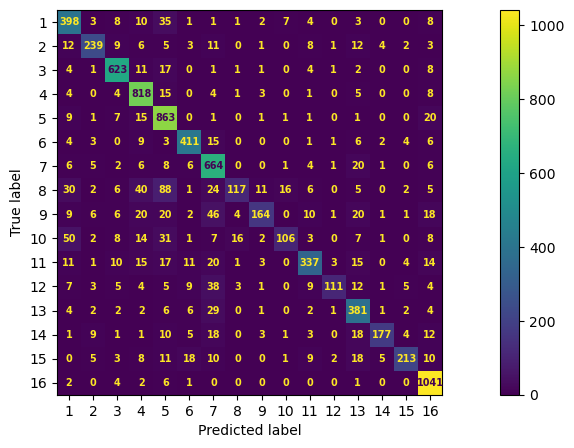

In [23]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train) 
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["viridis"]);

When looking at the metrics for SDG 1, we find that:

 - $tp = 398$ (where predicted label and true label are the same),
 - $fp = 153$ (calculated by summing vertically below 398),
 - $fn = 83$ (calculated by summing horizontally to the right of 398).

:::{admonition} Exercise 2.9
 Use the above values and formulas to calculate precision, recall, and f1 for SDG 1.
:::

## More Exercises

::::{admonition} Exercise 2.10
Using the UN SDG dataset, begin working with some of the `scikit-learn` NLP capabilities, such as the following code:

```
docs = text_df.text
count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(docs).toarray()
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
```

Try out different parameters in `CountVectorizer`, including

```
ngram_range = (1,2)
stop_words='english'
min_df = 2
min_df = 3
```

What are the most frequent unigrams, bigrams, and trigrams? Answer this question with, and then without, stop word removal.
::::

:::{admonition} Exercise 2.11
Write a function that takes in the a document corpus prepared in the exercises from Section 1 that returns:
 - The top 50 most frequent words,
 - A plot of the cumulative word count from the most frequent word to the 50th most frequent, and
 - A comparison of the level of cumulation (i.e., the height where the plot ends) with the total number of words of the input corpus, outputting the percentage.

Your function should also contain a parameter `stop_word` with its default set to "None", which does not remove stop words.
:::

:::{admonition} Exercise 2.12
Run your function from Exercise 2.11 on the documents labeled with SDG 8. What is the output?
:::

:::{admonition} Exercise 2.13
Run your function from Exercise 2.11 on the entire UN SDG corpus, once with stop removal and once without. Describe the similarities and differences in the outputs when this parameter is changed.
:::